In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport VQE, GroupingAlgorithm, HEEM_VQE_Functions, utils

import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from utils import *
from qiskit import IBMQ
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.test.mock import FakeMelbourne
import os
from joblib import Parallel, delayed
from IPython.display import display, clear_output
from GroupingAlgorithm import grouping_shuffle
from tqdm.notebook import tqdm_notebook
from qiskit.visualization import plot_gate_map
from GroupingAlgorithm import grouping
from utils import Label2Chain
from joblib import Parallel, delayed

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [14]:
def callback(evals, params, mean, deviation):  
    print("{}, {}".format(evals, mean))

def run_VQE(solver, qubitop):    
    evaluations = []
    solution = solver.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
    return solver.energies

In [15]:
backend = Aer.get_backend('qasm_simulator')
device_backend = FakeMelbourne()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
NUM_SHOTS = 2 ** 5  # Number of shots for each circuit
maxiter = 1
qi = QuantumInstance(backend=backend, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=NUM_SHOTS)
basis = [4, 6, 7, 8, 9, 5, 3, 2, 1]

In [ ]:
qubit_op, init_state = BeH2(initial_state=True)
qubit_op = grouping_shuffle(qubit_op, basis, coupling_map)
num_qubits = qubit_op.num_qubits
optimizer = SPSA(maxiter=maxiter, last_avg=1)
ansatz = init_state.compose(EfficientSU2(num_qubits, ['ry', 'rz'], entanglement='linear', reps=1))
num_var = ansatz.num_parameters
initial_params = [0.1] *num_var

solver_TPB = VQE(ansatz, optimizer, initial_params, grouping='TPB',
                 quantum_instance=qi, callback=callback, order=basis, transpile=True)
solver_EM = VQE(ansatz, optimizer, initial_params, grouping='Entangled',
                quantum_instance=qi, callback=callback, order=basis, transpile=True)
solver_HEEM = VQE(ansatz, optimizer, initial_params, grouping='Entangled',
                  quantum_instance=qi, callback=callback, order=basis, conectivity=coupling_map, transpile=True)

solvers = [solver_TPB, solver_EM, solver_HEEM]

exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op).eigenvalue.real

Computing optimal order:   0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
E_TPB, E_EM, E_HEEM = Parallel(n_jobs=3)(delayed(run_VQE)(solver, qubit_op) for solver in solvers)

In [23]:
file = '../data/simulation_BeH'
np.savez(file, NUM_SHOTS=NUM_SHOTS, maxiter=maxiter, basis=basis, E_TPB=E_TPB, E_EM=E_EM, E_HEEM=E_HEEM, E_EXACT=exact)

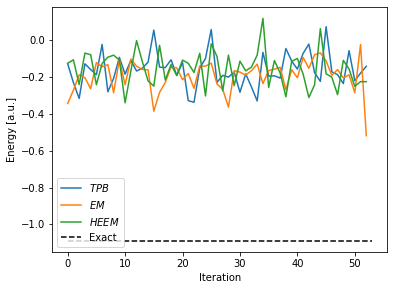

In [32]:
data = np.load(file + '.npz')

E_EXACT = data['E_EXACT']
E_TPB = data['E_TPB']
E_EM = data['E_EM']
E_HEEM = data['E_HEEM']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4.5))
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy [a.u.]')

ax.plot(E_TPB)
ax.plot(E_EM)
ax.plot(E_HEEM)
ax.hlines(E_EXACT,0, len(E_TPB), color='black', linestyle='--')

ax.legend(['$TPB$', '$EM$', '$HEEM$', 'Exact'])

# plt.savefig("../Figures/E vs d.pdf")